In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

In [2]:
import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp

In [3]:
mod = ge.model_from_gcn("../GCN Files/Sims_2024_NK_money_growth.gcn")

Model Building Complete.
Found:
	16 equations
	16 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	10 parameters
		 9 / 10 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
epsilons = np.linspace(2, 20, 100)
epsilon_df = pd.DataFrame(
    np.vectorize(mod.steady_state)(epsilon=epsilons, sigma=1.0).tolist(), index=epsilons
)

<Axes: >

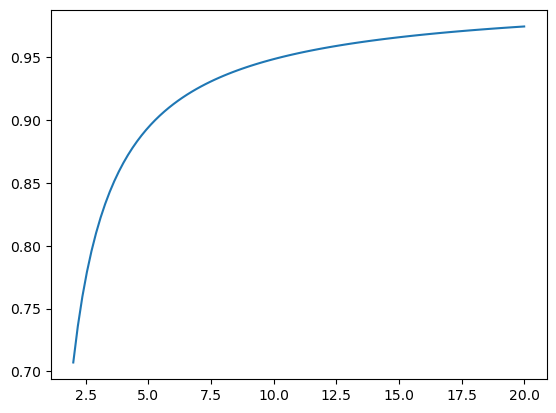

In [5]:
epsilon_df.Y_ss.plot()

In [6]:
g_M_values = np.linspace(-0.005, 0.01, 100)
ss_g_M = pd.DataFrame(
    [mod.steady_state(g_M=g_M, sigma=1.0) for g_M in g_M_values], index=g_M_values
)

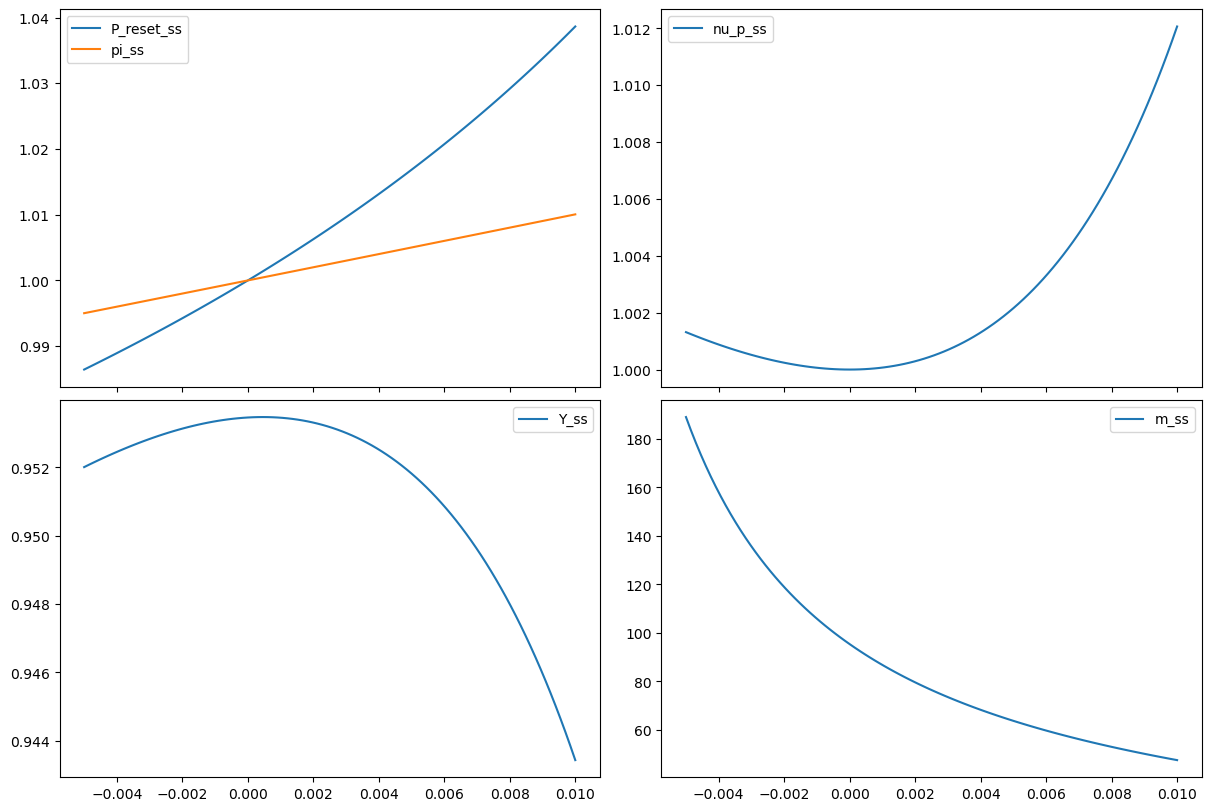

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, layout="constrained")
variables = [["P_reset_ss", "pi_ss"], ["nu_p_ss"], ["Y_ss"], ["m_ss"]]
for vars, axis in zip(variables, fig.axes):
    ss_g_M[vars].plot(ax=axis)
plt.show()

In [8]:
irf_params = {
    "beta": 0.99,
    "sigma": 3.0,
    "chi": 1,
    "theta": 1,
    "phi": 3 / 4,
    "epsilon": 11,
    "psi": 1,
    "g_M": 0.0,
    "rho_M": 0.5,
    "rho_A": 0.9,
}
irf = ge.impulse_response_function(
    mod,
    **irf_params,
    shock_size={"epsilon_A": 0.01, "epsilon_M": 0.01},
    simulation_length=20,
    log_linearize=True,
)

The following variables had steady-state values close to zero and will not be log-linearized:['g_M_t']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


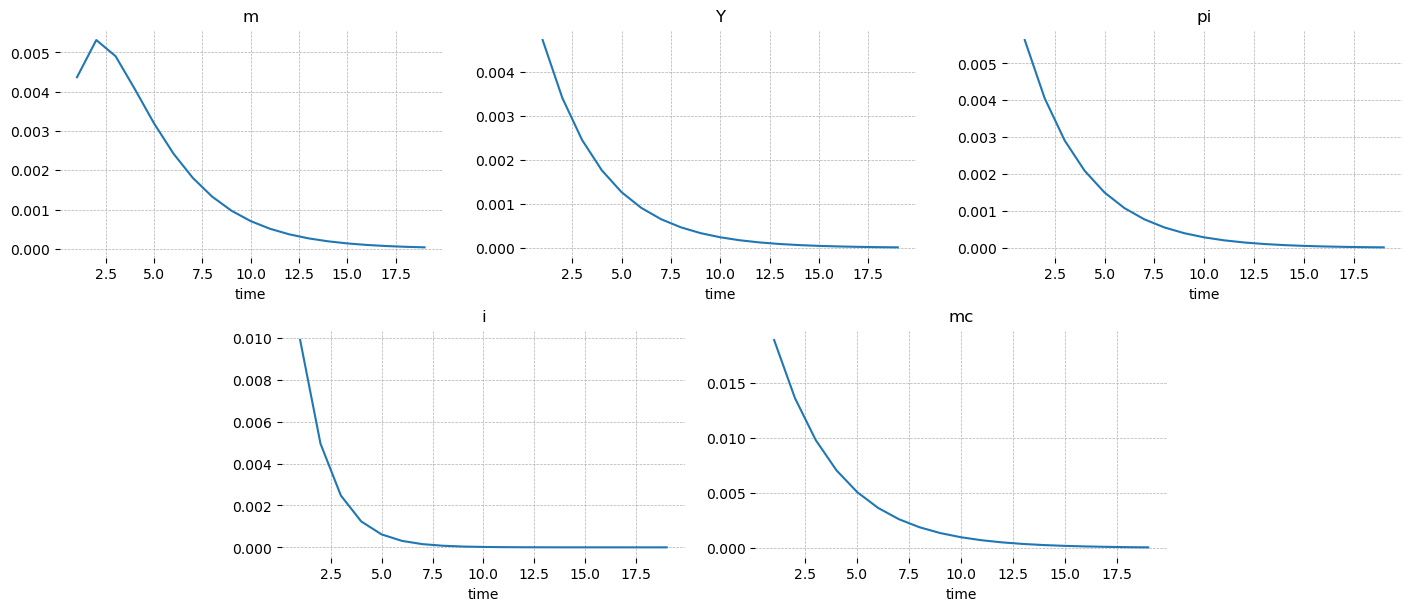

In [9]:
import gEconpy.plotting as gp

gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["m", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_M"],
    n_cols=3,
    figsize=(14, 6),
);

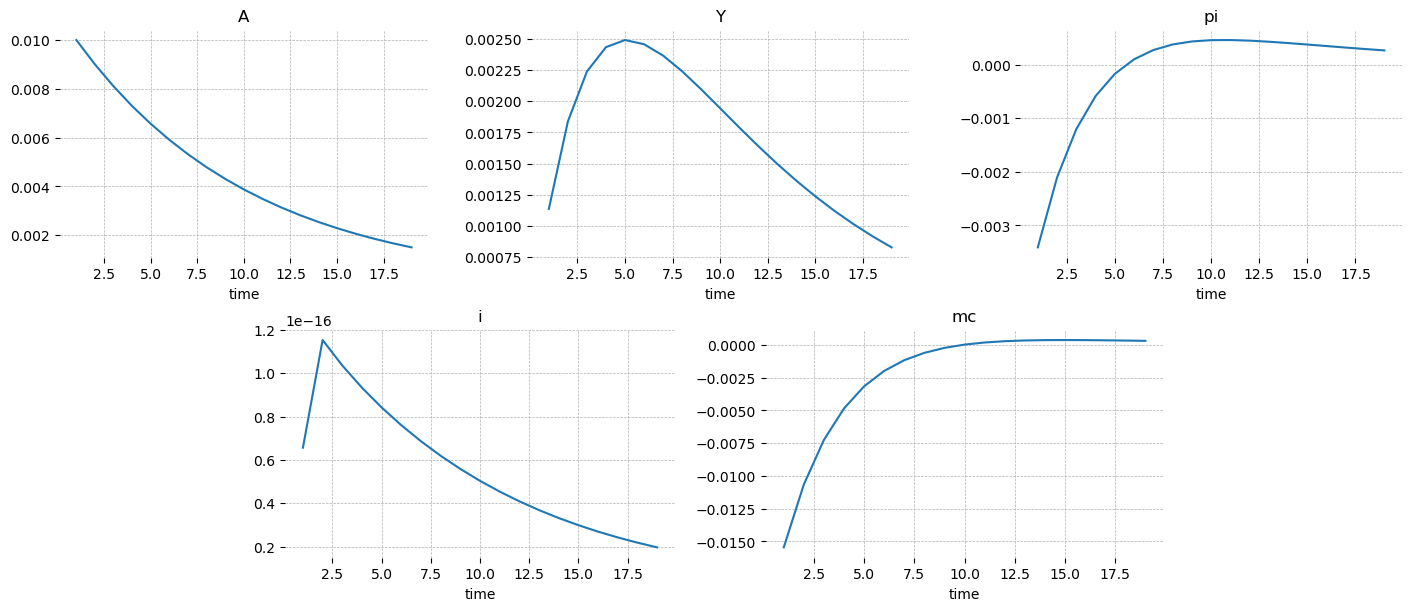

In [10]:
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["A", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

In [11]:
irf_by_phi = {
    f"phi = {phi}": ge.impulse_response_function(
        mod,
        **(irf_params | {"phi": phi, "g_M": 0.001}),
        shock_size={"epsilon_A": 0.01, "epsilon_M": 0.01},
        simulation_length=20,
        log_linearize=True,
        verbose=False,
    ).isel(time=slice(1, None))
    for phi in [0, 0.75, 0.9]
}

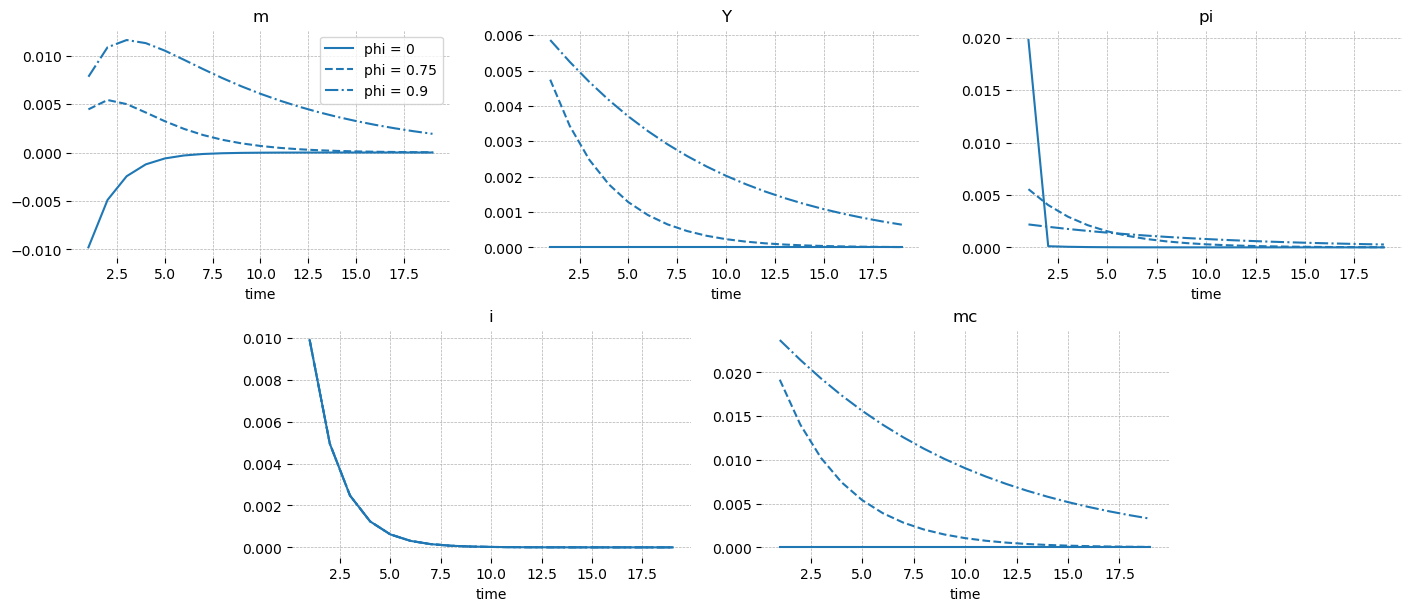

In [12]:
gp.plot_irf(
    irf_by_phi,
    vars_to_plot=["m", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_M"],
    n_cols=3,
    figsize=(14, 6),
);

The following variables had steady-state values close to zero and will not be log-linearized:['g_M_t']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


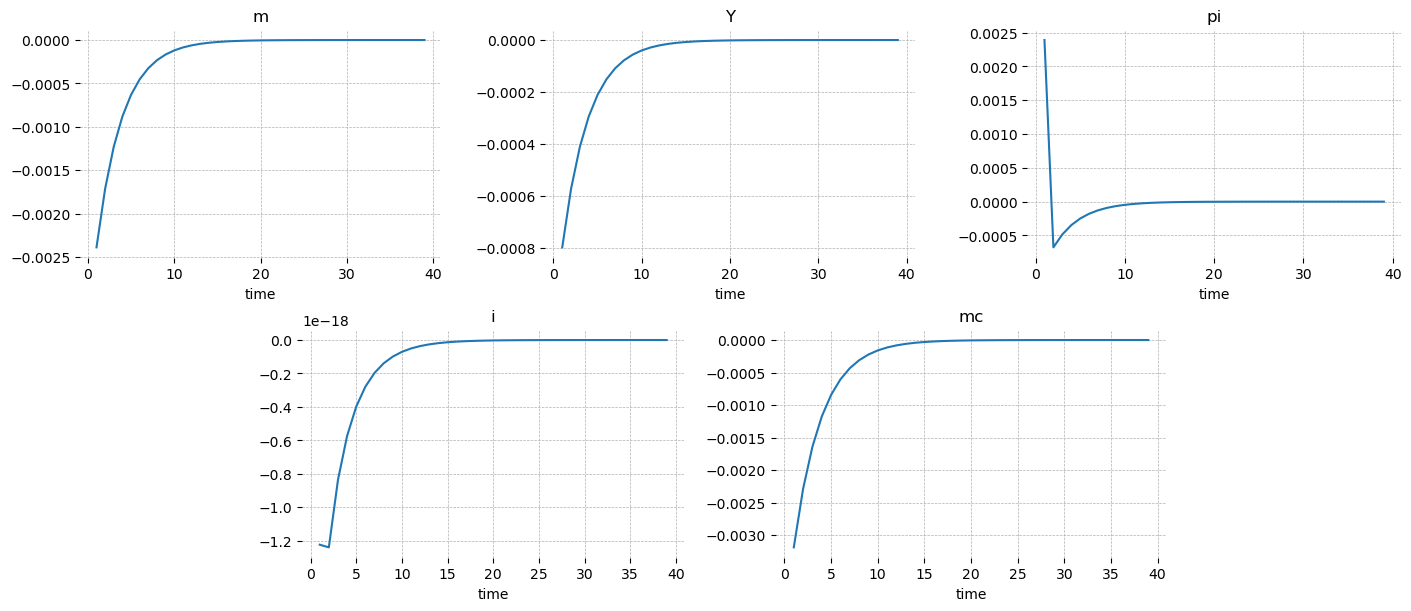

In [13]:
irf = ge.impulse_response_function(mod, shock_size={"epsilon_markup": 0.01})
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["m", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_markup"],
    n_cols=3,
    figsize=(14, 6),
);

In [16]:
T, R = mod.solve_model(g_M=0.001, phi=0.9)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [17]:
ge.matrix_to_dataframe(T, mod).round(3)

,A,C,N,P_reset,SDF,X_hat_1,X_hat_2,Y,g_M,i,lambda,m,mc,nu_p,pi,w
A,0.900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,0.0,0.0,-0.000,0.0,0.000,0.0,0.0
C,0.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.297,0.0,-0.014,0.0,0.0
N,-0.882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.309,0.0,0.900,0.0,0.0
P_reset,-0.802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,1.095,0.0,0.425,0.0,0.0
SDF,-0.080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001,0.0,-1.0,-0.890,0.0,0.043,0.0,0.0
X_hat_1,-2.216,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.006,-0.0,-0.0,6.176,-0.0,1.233,-0.0,-0.0
X_hat_2,-1.413,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.005,-0.0,-0.0,5.081,-0.0,0.808,-0.0,-0.0
Y,0.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.297,0.0,-0.014,0.0,0.0
g_M,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0,-0.000,0.0,-0.000,0.0,0.0
i,0.000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.000,-0.0,-0.0,0.000,-0.0,-0.000,-0.0,-0.0


In [18]:
ge.matrix_to_dataframe(R, mod).round(3)

,epsilon_A,epsilon_M,epsilon_markup
A,1.000,-0.000,0.000
C,0.030,0.587,-0.030
N,-0.980,0.611,-0.020
P_reset,-0.892,2.185,0.887
SDF,-0.089,-1.760,0.089
X_hat_1,-2.462,12.329,-0.597
X_hat_2,-1.570,10.143,-0.494
Y,0.030,0.587,-0.030
g_M,0.000,1000.000,-0.000
i,0.000,0.989,-0.000


In [19]:
ss_mod = ge.statespace_from_gcn("../GCN Files/Sims_NK_2024.gcn")

Model Building Complete.
Found:
	16 equations
	16 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	10 parameters
		 9 / 10 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


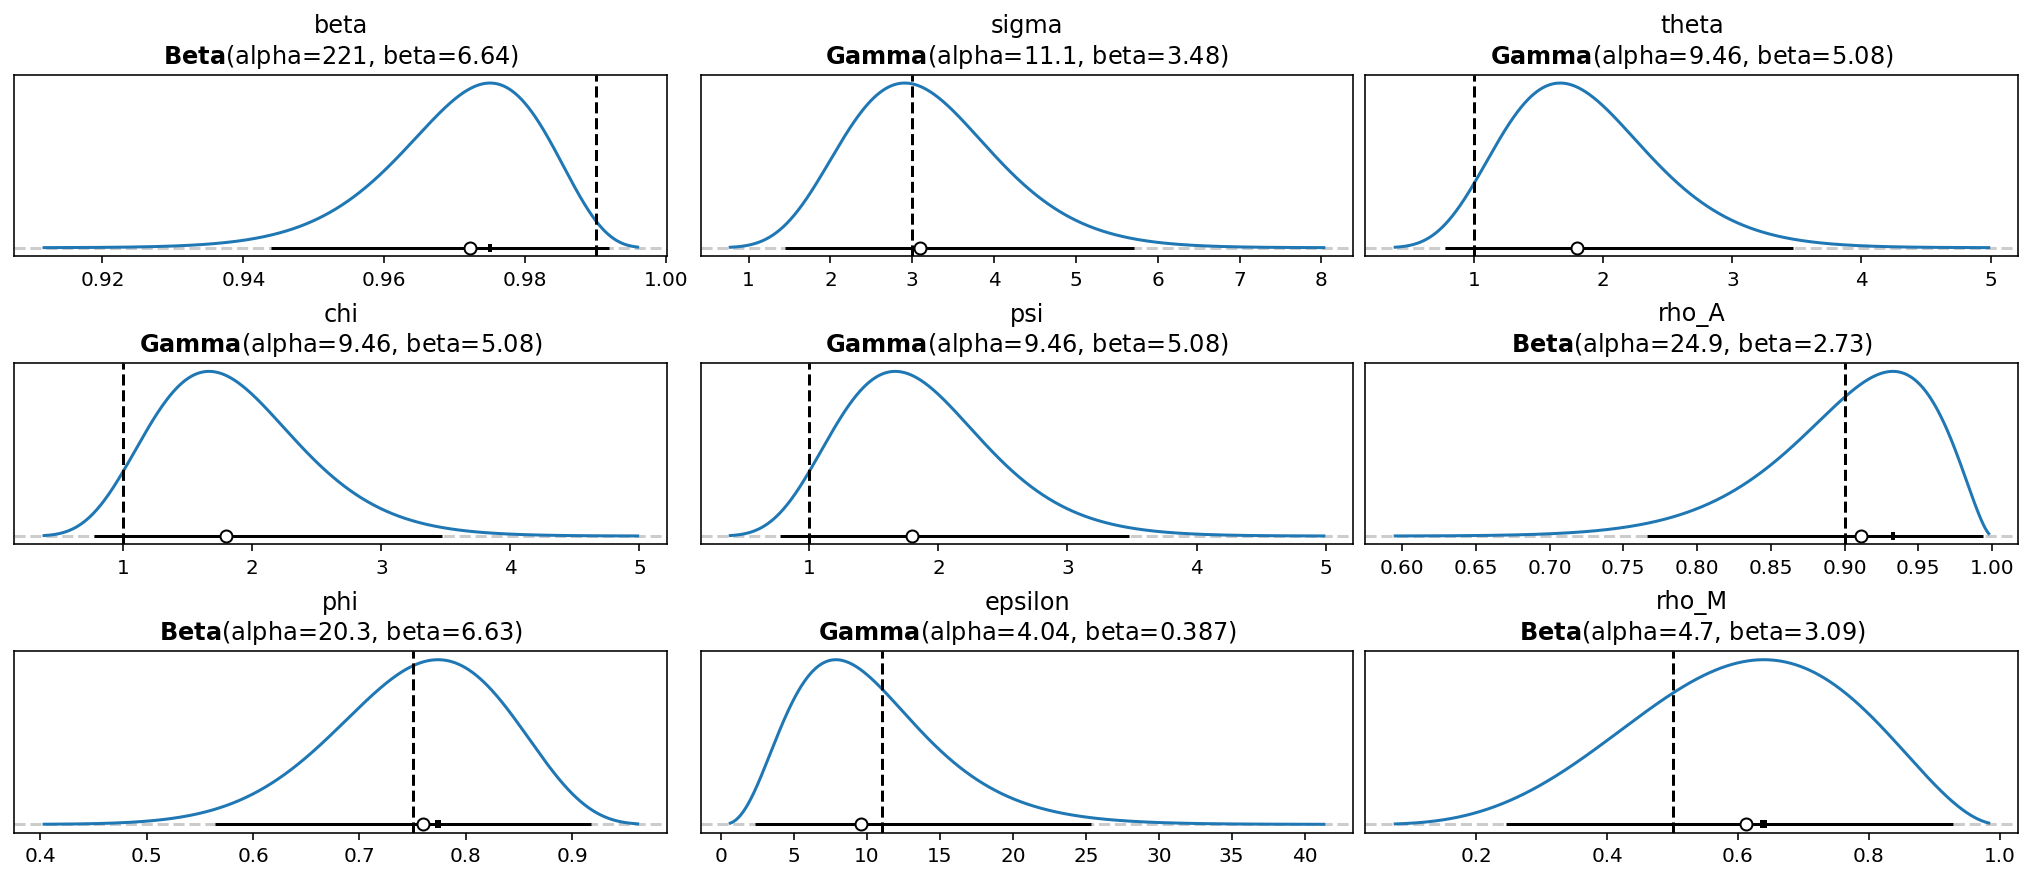

In [20]:
gp.plot_priors(ss_mod, n_cols=3);

In [21]:
ss_mod.configure(
    observed_states=["Y", "C", "N", "pi", "i", "m", "w", "g_M"],
    measurement_error=["Y", "C", "N", "m", "w"],
    constant_params=["g_M"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	epsilon -- shape: (), constraints: None, dims: None
	phi -- shape: (), constraints: None, dims: None
	psi -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_M -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constraints: None, dims: None
	state_cov -- shape: (3, 3), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dims: None
	error_sigma_C -- shape: (), constraints: None, dims: None
	error_sigma_N -- shape: (), constraints: None, dims: None
	error_sigma_m -- shape: (), constraints: None, dims: None
	error_sigma_w -- shape: (), constraints: None, dims: None


In [22]:
import pymc as pm
import preliz as pz

dates = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
dummy_data = pd.DataFrame(np.nan, index=dates, columns=ss_mod.observed_states)

all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=3, eta=6, sd_dist=pm.HalfNormal.dist(sigma=0.05)
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

    ss_mod.build_statespace_graph(
        dummy_data,
        add_bk_check=False,
        add_solver_success_check=True,
        add_norm_check=True,
        add_steady_state_penalty=True,
    )

    prior = pm.sample_prior_predictive()

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_65656/758441464.py:28: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [beta, chi, epsilon, error_sigma_C, error_sigma_N, error_sigma_Y, error_sigma_m, error_sigma_w, obs, phi, psi, rho_A, rho_M, sigma, state_chol, theta]


In [23]:
prior_trajectories = ss_mod.sample_unconditional_prior(prior)

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x16AF5D620>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


Output()

In [24]:
idx = np.random.choice(prior.prior.coords["draw"].values)

true_params = prior.prior.isel(chain=0, draw=idx)
data = prior_trajectories.isel(chain=0, draw=idx).prior_observed
data = (
    data.to_dataframe()
    .drop(columns=["chain", "draw"])
    .unstack("observed_state")
    .droplevel(axis=1, level=0)
)

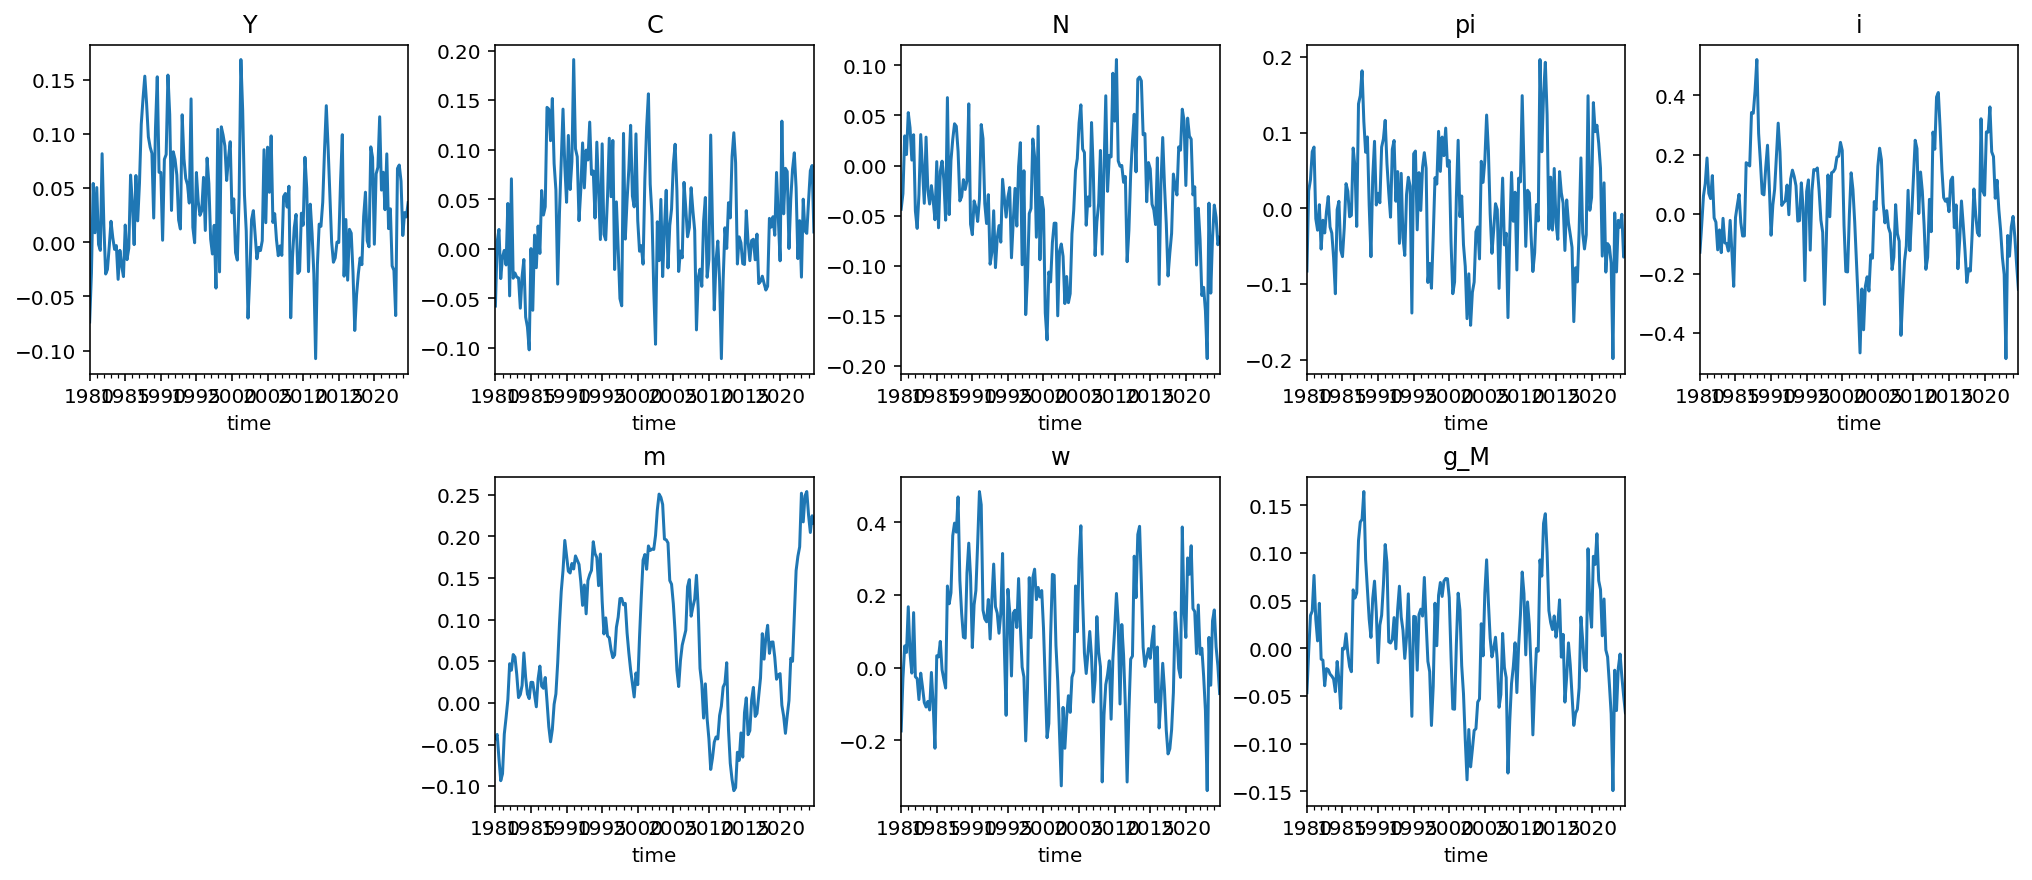

In [25]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

In [26]:
with pm_mod:
    pm.set_data({"data": data})
    ss_mod._fit_data = data

In [27]:
from pymc.model.transform.optimization import freeze_dims_and_data
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=None,
)

In [28]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-4,
        num_layers=10,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=2000,
    draws=1000,
    chains=6,
    transform_adapt=False,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,4,0.34,15
,3000,2,0.35,23
,3000,8,0.35,15
,3000,3,0.35,15
,3000,1,0.35,15
,3000,1,0.37,15


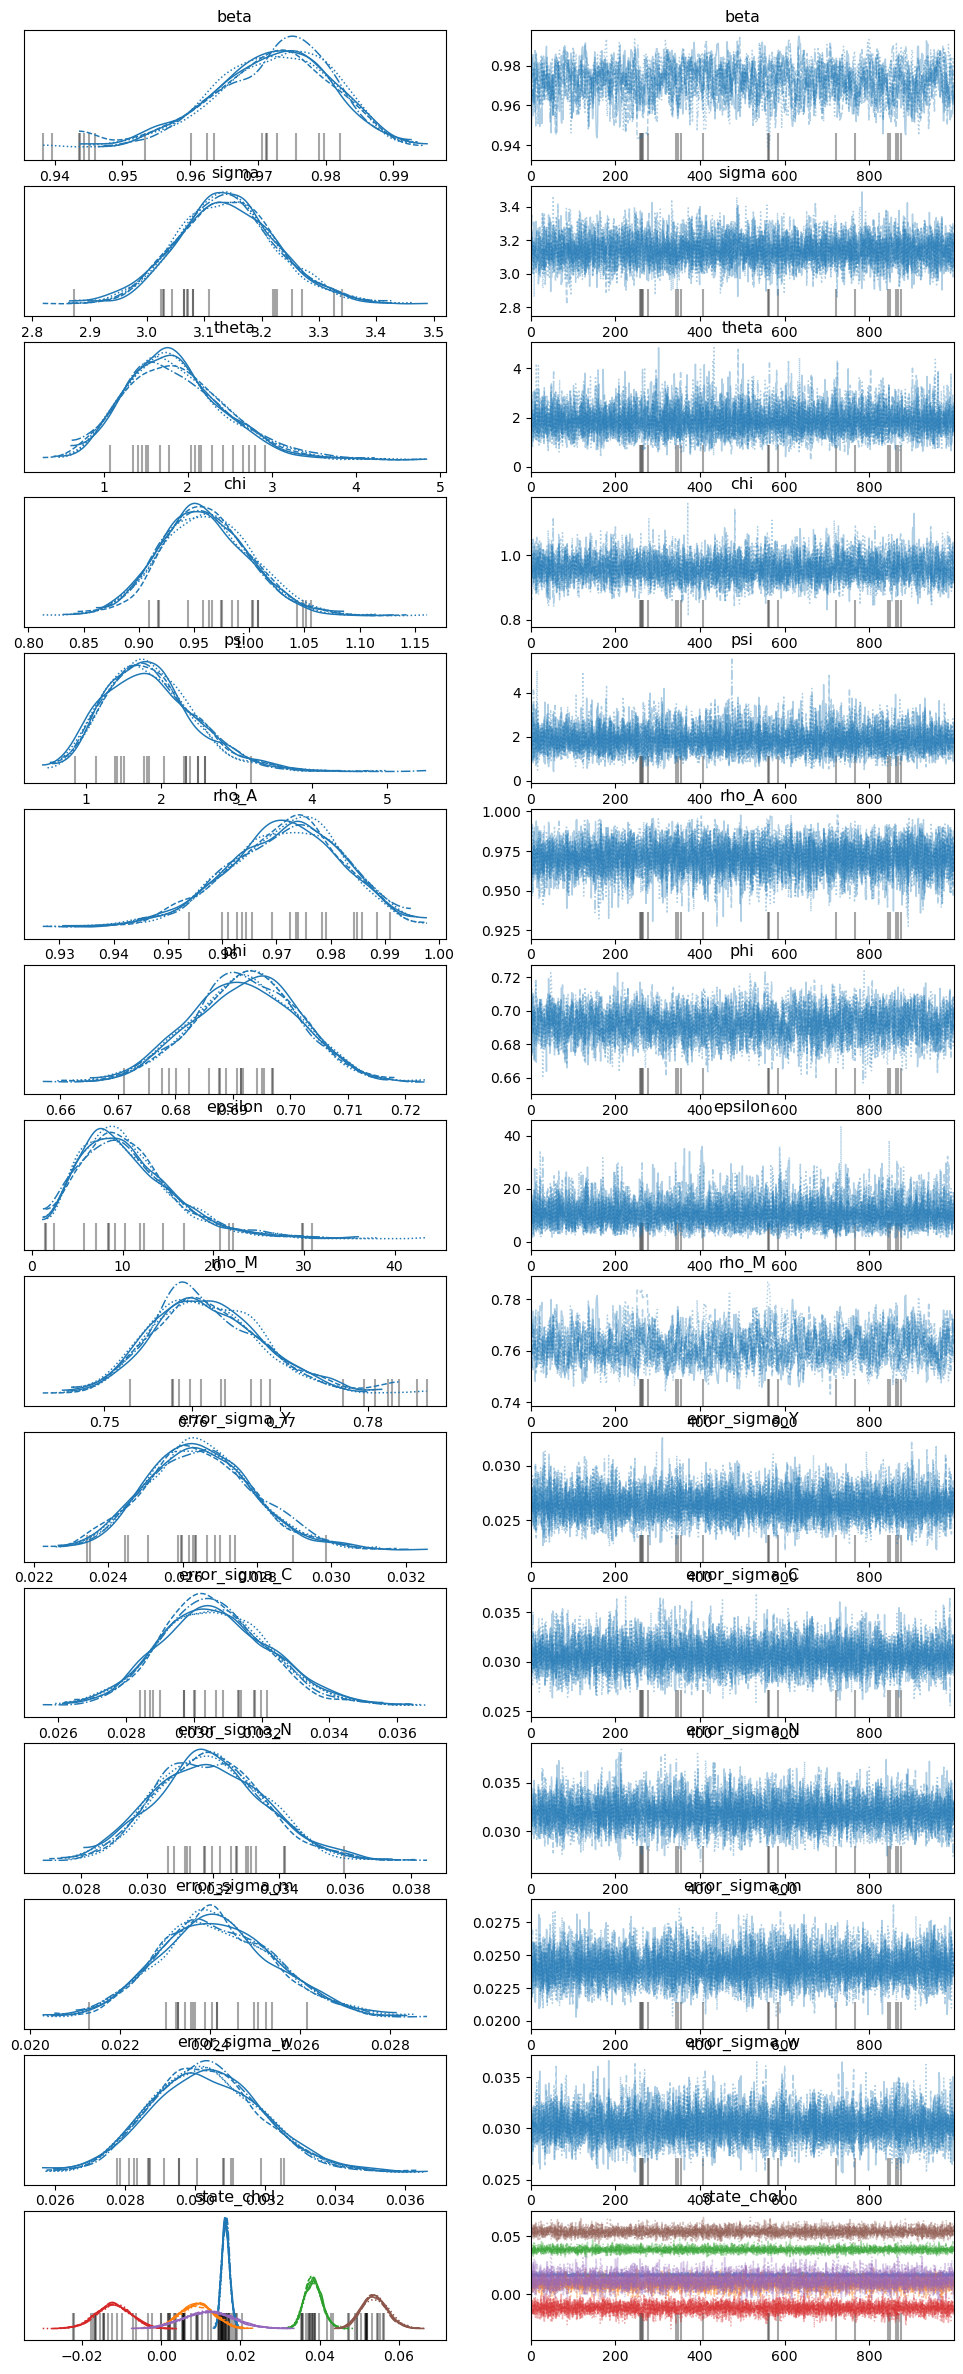

In [29]:
import arviz as az

var_names = [rv.name for rv in pm_mod.free_RVs]
az.plot_trace(idata, var_names=var_names);

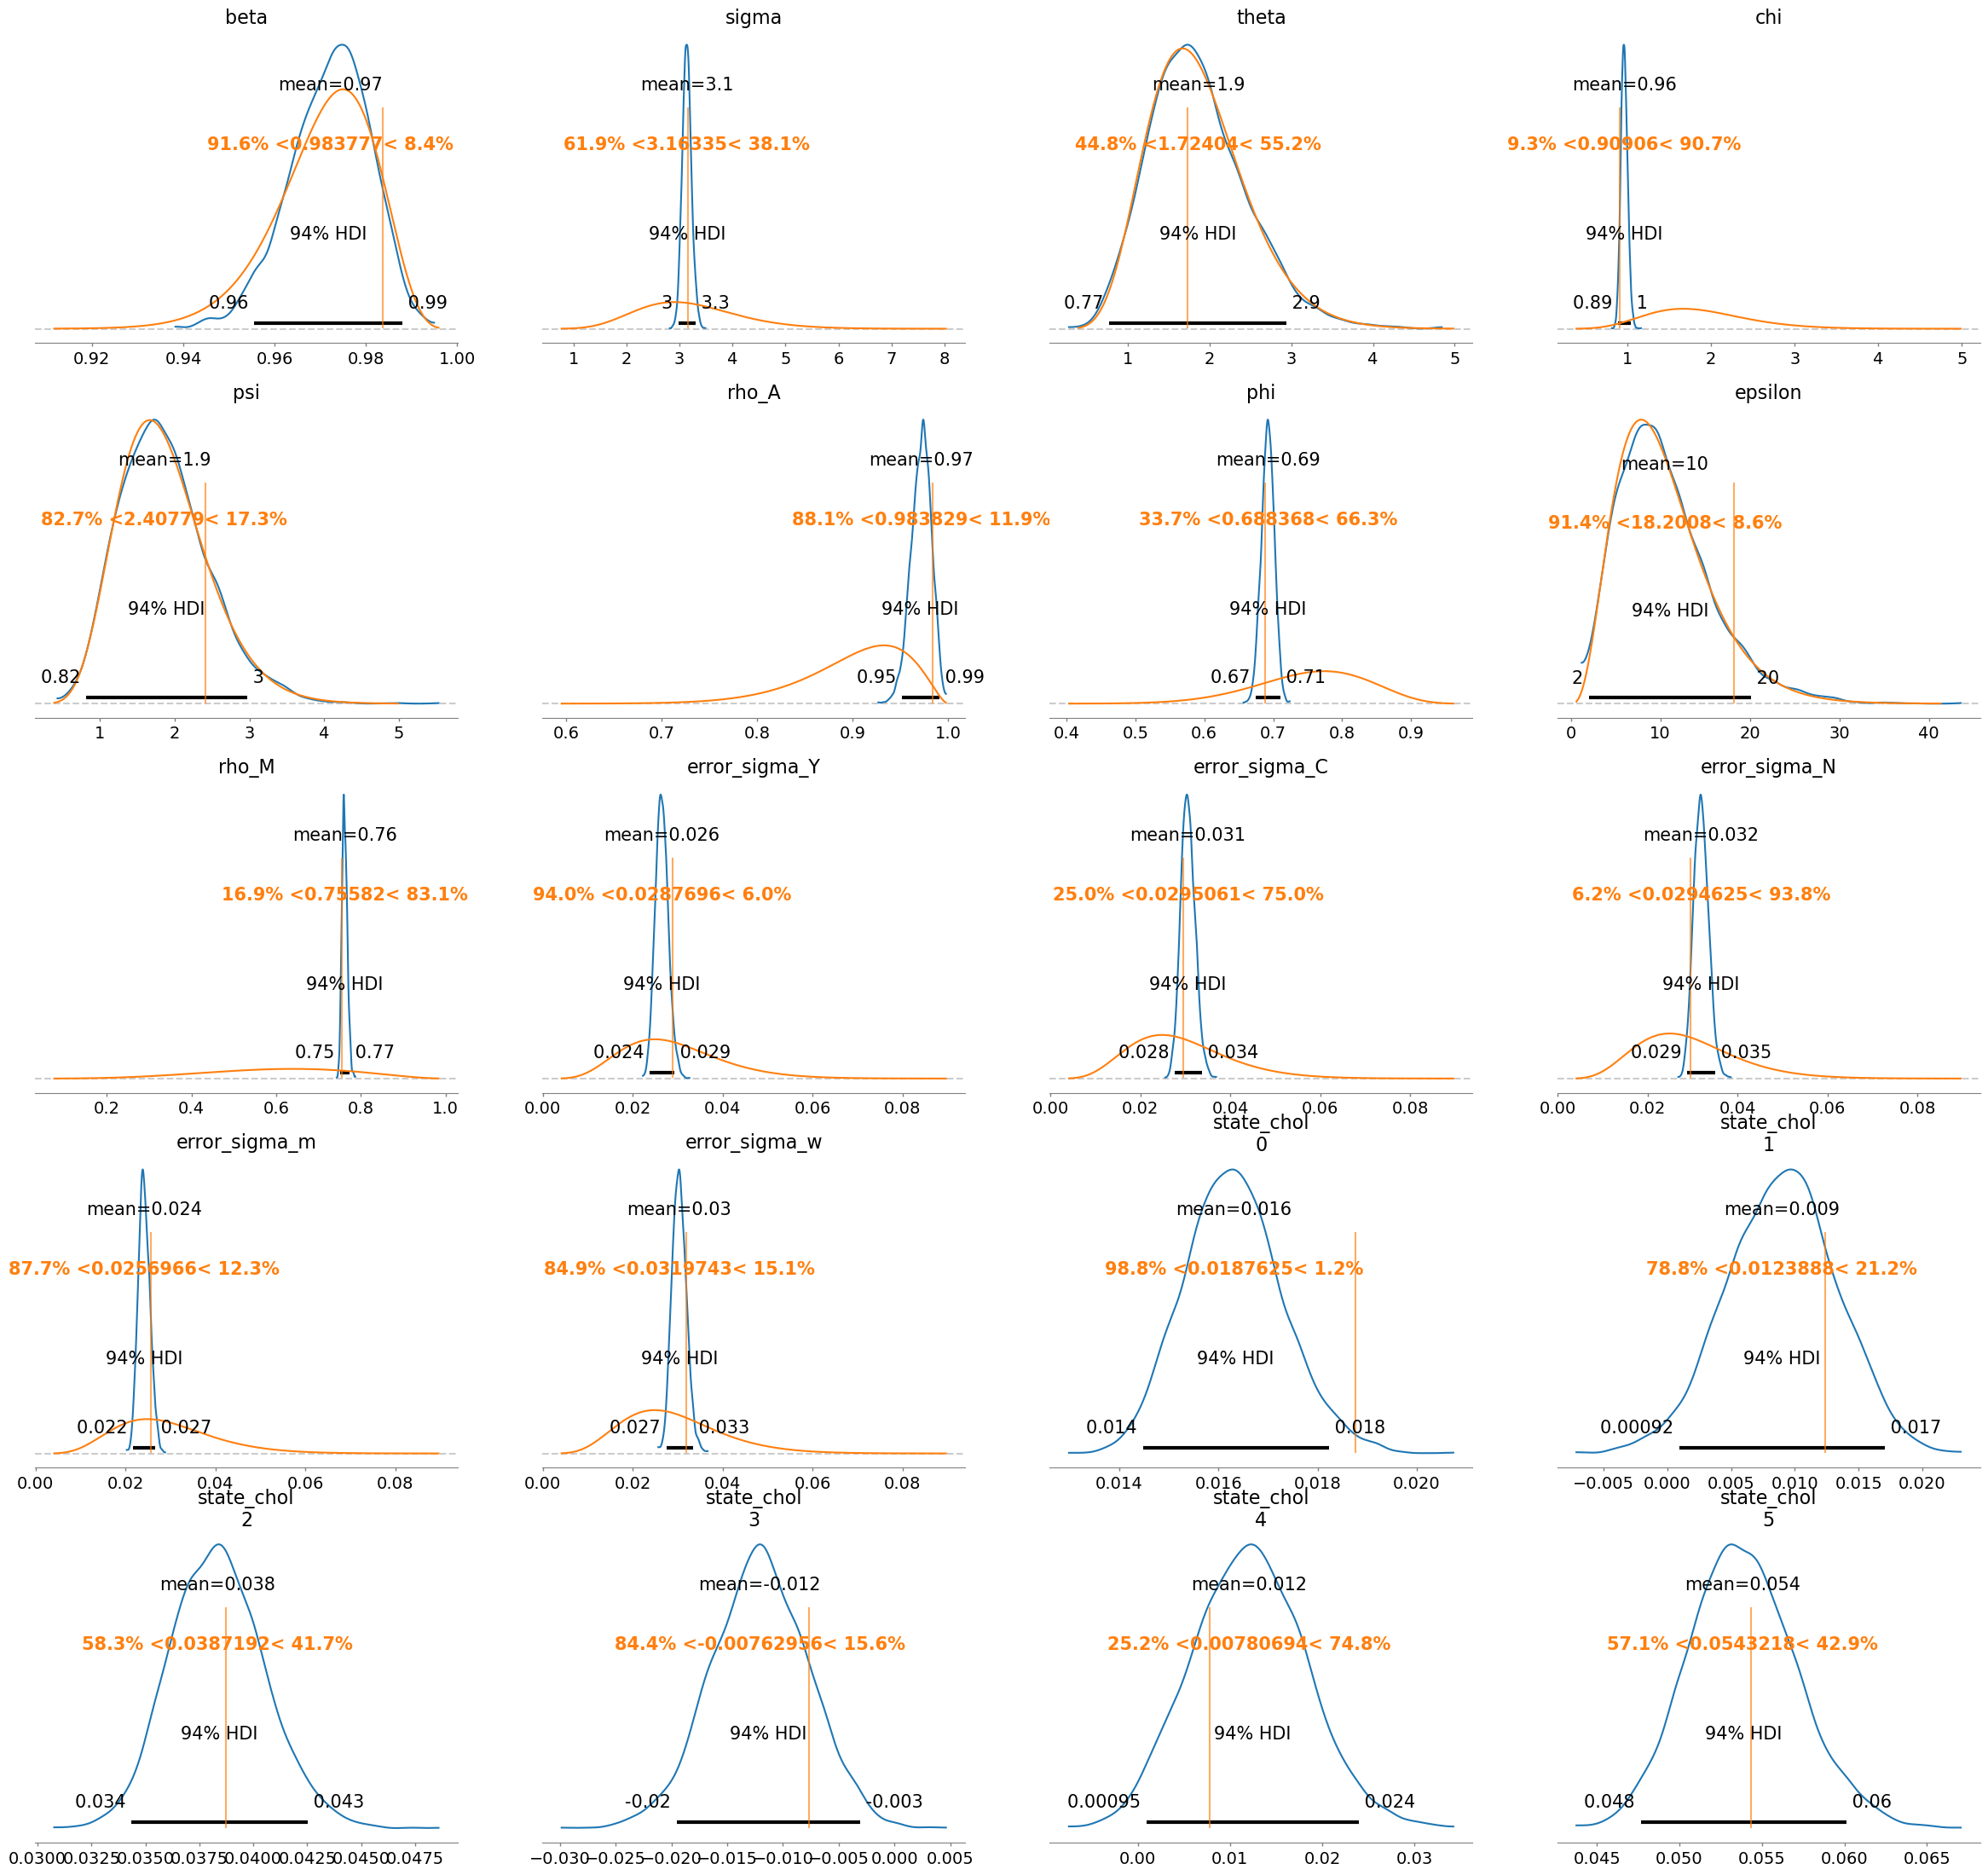

In [30]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")